In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout


### Load Dataset

In [29]:
match_1 = pd.read_json("game1.json")
match_2 = pd.read_json("game2.json")

## Get to know the data


In [3]:
match_1.head(5)

,label,norm
0,walk,"[23.177037336396975, 23.361525285249378, 21.53..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88..."


In [4]:
print(match_1.shape)
print(match_2.shape)

(574, 2)
(613, 2)


In [5]:
match_1.describe()


,label,norm
count,574,574
unique,8,574
top,walk,"[23.177037336396975, 23.361525285249378, 21.53..."
freq,245,1


In [6]:
match_2.describe()

,label,norm
count,613,613
unique,9,613
top,run,"[104.42423889328715, 87.63989343949717, 128.52..."
freq,343,1


## One dataset has 8 unique labels and second dataset has 9 unique labels

In [8]:
print(match_1['label'].unique())
print(match_2['label'].unique())

['walk' 'rest' 'run' 'tackle' 'dribble' 'pass' 'cross' 'shot']
['no action' 'run' 'pass' 'rest' 'walk' 'dribble' 'shot' 'tackle' 'cross']


### Frequency value 50HZ is given, so we can calculate time taken for each gait.


In [9]:
match_1['time'] = match_1['norm'].apply(lambda x: len(x)/50)
match_2['time'] = match_2['norm'].apply(lambda x: len(x)/50)

match_1.head(5)

,label,norm,time
0,walk,"[23.177037336396975, 23.361525285249378, 21.53...",1.44
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...",1.08
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...",1.36
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...",1.50
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...",3.62


In [12]:
print(match_1["label"].value_counts())


label
walk       245
run        209
dribble     42
rest        25
pass        24
tackle      20
shot         6
cross        3
Name: count, dtype: int64


In [13]:
print(match_2["label"].value_counts())


label
run          343
walk         190
dribble       36
shot          12
tackle        11
rest          10
pass           8
no action      2
cross          1
Name: count, dtype: int64


### Plotting the data


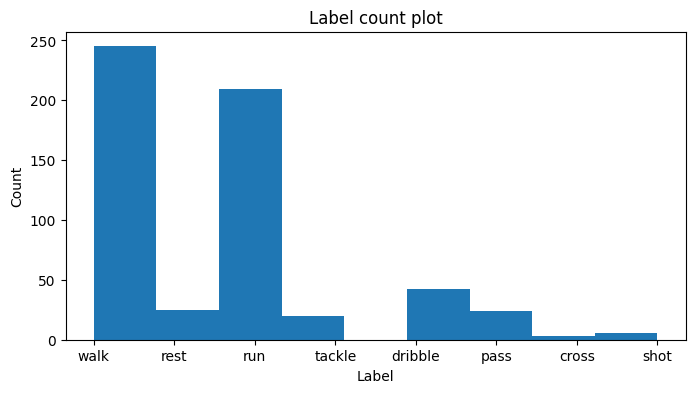

In [14]:
plt.figure(figsize=(8,4))
plt.hist(match_1['label'], bins=9)
plt.title("Label count plot")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


## Data is extremely unbalanced


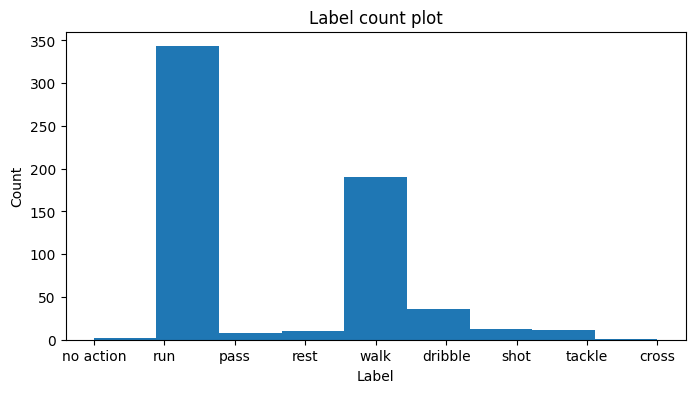

In [15]:
plt.figure(figsize=(8,4))
plt.hist(match_2['label'], bins=9)
plt.title("Label count plot")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Approach

### To regenerate the game, using the given data, we can use random selection of actions.
### As we have the time calculated, one solution is that take the desired duration of game as input and genrate sequence from the given data randomly, compare each time the total time duration.


In [16]:
game = pd.concat([match_1,match_2],ignore_index=True)
game['time'] = game['norm'].apply(lambda x: len(x) / 50)

def select_random_action(current_time, total_duration):
    '''

    :param current_time: updated time in each new item in the sequence
    :param total_duration: total game duration
    :return:
    '''
    all_actions = game[
        (game['time'] + current_time <= total_duration) & (game['time'] > 0.1) & (game['time'] < 3.0)]
    if len(all_actions) == 0:
        return None
    return all_actions.sample(1).iloc[0]

def regenerate(total_duration=400):
    '''

    :param total_duration: Duration of the regenerated game
    :return: sequence of actions and norm
    '''
    current_time = 0
    generated_data = pd.DataFrame(columns=['label', 'norm'])
    max_occurance = 3
    previous_label = None
    consecutive_occurance_count = 0
    while current_time < total_duration:
        # Select a random action
        selected_action = select_random_action(current_time, total_duration)

        # Ensure that a valid action was selected
        if selected_action is None:
            break

        # Check if the selected label is the same as the previous label
        if selected_action['label'] == previous_label:
            consecutive_occurance_count += 1
            if consecutive_occurance_count > max_occurance:
                continue
        else:
            consecutive_occurance_count = 0

        generated_data = pd.concat([generated_data, selected_action.to_frame().T], ignore_index=True)
        current_time += selected_action['time']
        previous_label = selected_action['label']

    generated_data.reset_index(drop=True, inplace=True)
    return generated_data[['label', 'norm']]



### Another way to generate the game is using RNN.
### RNN is an option because our data is in the form of sequence. and RNN is a best option when the order of sequemce matters.

## Prepocessing data for RNN

In [17]:
x_train = match_1['norm'].tolist()
y_train = match_1['label'].tolist()

### As two dataset has different labels, and dataset size is small, I use manual encoding.


In [18]:
labels = pd.concat([match_1['label'],match_2['label']])
unique_labels = labels.unique()
label_map = {label: num for num, label in enumerate(unique_labels)}
label_map

{'walk': 0,
 'rest': 1,
 'run': 2,
 'tackle': 3,
 'dribble': 4,
 'pass': 5,
 'cross': 6,
 'shot': 7,
 'no action': 8}

In [19]:
#Encode the labels
y_train_encoded = [label_map[label] for label in y_train]
y_train_encoded = np.array(y_train_encoded)

## As considering norm as x_train, need to pad the data to make it same length

In [20]:
# Pad the data
max_sequence_length = max(len(seq) for seq in x_train)
print('Max sequence length:', max_sequence_length)
X_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_sequence_length)
X_train_padded

Max sequence length: 227


array([[ 0,  0,  0, ..., 17, 21, 21],
       [ 0,  0,  0, ..., 24, 21, 18],
       [ 0,  0,  0, ..., 22, 20, 20],
       ...,
       [ 0,  0,  0, ..., 86, 46, 53],
       [ 0,  0,  0, ..., 53, 49, 23],
       [ 0,  0,  0, ..., 24, 30, 29]], dtype=int32)

In [21]:
print(X_train_padded.shape)
print(y_train_encoded.shape)

(574, 227)
(574,)


In [22]:
#Reshape the input data to include a time step dimension of size 1
x_train = X_train_padded.reshape((X_train_padded.shape[0], 1,X_train_padded.shape[1]))
x_train.shape

(574, 1, 227)

## Build the model


In [23]:

model = keras.Sequential()
model.add(LSTM(units=64, input_shape=(1, max_sequence_length), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=64))
model.add(Dropout(0.4))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             74752     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 108361 (423.29 KB)
Trainable params: 108361 (423.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model

In [24]:
model.fit(x_train, y_train_encoded, epochs=80, batch_size=100)


Epoch 1/80
6/6 [==============================] - 2s 3ms/step - loss: 2.1631 - accuracy: 0.1725
Epoch 2/80
6/6 [==============================] - 0s 2ms/step - loss: 2.0592 - accuracy: 0.3937
Epoch 3/80
6/6 [==============================] - 0s 3ms/step - loss: 1.9356 - accuracy: 0.5000
Epoch 4/80
6/6 [==============================] - 0s 2ms/step - loss: 1.8016 - accuracy: 0.4878
Epoch 5/80
6/6 [==============================] - 0s 4ms/step - loss: 1.6426 - accuracy: 0.5488
Epoch 6/80
6/6 [==============================] - 0s 3ms/step - loss: 1.5173 - accuracy: 0.5244
Epoch 7/80
6/6 [==============================] - 0s 2ms/step - loss: 1.4237 - accuracy: 0.5383
Epoch 8/80
6/6 [==============================] - 0s 2ms/step - loss: 1.3467 - accuracy: 0.5592
Epoch 9/80
6/6 [==============================] - 0s 3ms/step - loss: 1.3010 - accuracy: 0.5767
Epoch 10/80
6/6 [==============================] - 0s 3ms/step - loss: 1.2767 - accuracy: 0.6237
Epoch 11/80
6/6 [======================

## Save the model

In [25]:
model.save('models/my_game_model.h5')


/Users/meghas/Megha/ML/my_game/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## To calculate the Accuracy

In [26]:
#load the model
model = keras.models.load_model('models/my_game_model.h5')
x_test = match_2['norm'].tolist()
y_test = match_2['label'].tolist()
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_sequence_length)
x_test = x_test.reshape((x_test.shape[0], 1,x_test.shape[1]))
predictions = model.predict(x_test)

20/20 [==============================] - 1s 728us/step


In [27]:
true_labels = np.array(y_test)
predicted_label = np.argmax(predictions, axis=1)
reverse_label_map = {num: label for num, label in enumerate(unique_labels)}
predicted_labels = [reverse_label_map[label] for label in predicted_label]
for i in range(len(true_labels)):
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

True label: no action, Predicted label: run
True label: run, Predicted label: run
True label: pass, Predicted label: pass
True label: rest, Predicted label: rest
True label: walk, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: pass
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: run, Predicted label: dribble
True label: run, Predicted label: dribble
True label: run, Predicted label: run
True label: run, Predicted label: walk
True label: run, Predicted label: run
True label: run, Predicted label: run
True label: walk, Predicted label: walk
True label: walk, Predicted label: walk
True label: walk, Predicted label: walk
True label: run, Predic